In [1]:
!pip install -U tensorflow==2.8 wandb==0.16

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

## Enable w&b logging

In [2]:
import wandb
wandb.login(key="fd9f24c89ea44085597d8689ee2472b1a6261015")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
config={
    "architecture": "Multimodal-Both",
    "input_shape": (32, 32, 3),
    "epochs": 50,
    "batch_size": 32,
    "seed": 44,
    "use_small_sample": False,
}

In [4]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ai-detection",

    # track hyperparameters and run metadata with wandb.config
    config=config
)

wandb: Currently logged in as: m-lechow13 (budalema). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240520_232609-q9ljwasc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cerulean-sound-110
wandb: ⭐️ View project at https://wandb.ai/budalema/ai-detection
wandb: 🚀 View run at https://wandb.ai/budalema/ai-detection/runs/q9ljwasc


## Set seed for reproducability

In [5]:
import numpy as np
import tensorflow as tf

SEED = config["seed"]

# Set random seed for NumPy
np.random.seed(SEED)

# Set random seed for TensorFlow
tf.random.set_seed(SEED)

In [6]:
import os

print(os.listdir("/kaggle/input"))

['cifake-real-and-ai-generated-synthetic-images', 'cifake-rgb-radiomic-features']


## Import data

In [7]:
image_path_train = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"

IMAGE_SIZE = (config["input_shape"][0], config["input_shape"][1])
BATCH_SIZE = None # do not batch - we want to perform shuffle

image_dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory=image_path_train,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
#     subset='training',
#     validation_split=0.1,
    seed=config["seed"],
    shuffle=False
)

# validation_dataset = tf.keras.utils.image_dataset_from_directory(
#     directory=image_path_train,
#     batch_size=BATCH_SIZE,
#     image_size=IMAGE_SIZE,
#     label_mode='categorical',
#     subset='validation',
#     validation_split=0.1,
#     seed=config["seed"],
# )

image_path_test = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

image_dataset_test = tf.keras.utils.image_dataset_from_directory(
    directory=image_path_test,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    shuffle=False,
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [8]:
# Get the class encoding from the generator
class_encoding = image_dataset_train.class_names

# Print the class encoding
print("Class Encoding:", class_encoding)

Class Encoding: ['FAKE', 'REAL']


In [9]:
import pandas as pd
df = pd.read_csv("/kaggle/input/cifake-rgb-radiomic-features/RGB_train_features.csv", index_col=0)
df_test = pd.read_csv("/kaggle/input/cifake-rgb-radiomic-features/RGB_test_features.csv", index_col=0)

In [10]:
def drop_columns(df, drop_only_diagnostic=False):
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            df.drop(column, axis=1, inplace=True)
        elif 'diagnostics' in column:
            df.drop(column, axis=1, inplace=True)
        elif 'Mask' in column:
            df.drop(column, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    to_drop = list()
    for column in df.columns:
        if column not in base_columns:
            to_drop.append(column)
            
    df.drop(to_drop, axis=1, inplace=True)

In [11]:
from sklearn.model_selection import train_test_split

preprocess_dataset(df, drop_only_diagnostic=True)
preprocess_dataset(df_test, drop_only_diagnostic=True)

X = df.drop('Category', axis=1)
y = df['Category']

Image = X['Image']
X = X.drop('Image', axis=1)

In [12]:
X.head()

,R_original_shape2D_Elongation,R_original_shape2D_MajorAxisLength,R_original_shape2D_MaximumDiameter,R_original_shape2D_MeshSurface,R_original_shape2D_MinorAxisLength,R_original_shape2D_Perimeter,R_original_shape2D_PerimeterSurfaceRatio,R_original_shape2D_PixelSurface,R_original_shape2D_Sphericity,R_original_firstorder_10Percentile,...,B_lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis,B_lbp-2D_gldm_LowGrayLevelEmphasis,B_lbp-2D_gldm_SmallDependenceEmphasis,B_lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,B_lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis,B_lbp-2D_ngtdm_Busyness,B_lbp-2D_ngtdm_Coarseness,B_lbp-2D_ngtdm_Complexity,B_lbp-2D_ngtdm_Contrast,B_lbp-2D_ngtdm_Strength
0,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-118.333224,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0
1,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-153.391086,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0
2,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-173.356861,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0
3,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-132.478270,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0
4,1.0,36.932371,44.553339,1023.5,36.932371,126.828427,0.123916,1024.0,0.894195,-129.649860,...,8.6875,1.0,0.119792,0.119792,0.119792,0.0,1000000.0,0.0,0.0,0.0


In [13]:
non_float_columns = X.select_dtypes(exclude=['float']).columns
print(non_float_columns)

Index([], dtype='object')


In [14]:
X_tensor = tf.convert_to_tensor(X)
X_tensor = tf.expand_dims(X_tensor, axis=0)
X_tensor = tf.reshape(X_tensor, (-1, 1, X.shape[1]))
# tf.reshape(X_tensor, [32, tf.size(X_tensor[0])])
tabular_dataset = tf.data.Dataset.from_tensor_slices(X_tensor)

In [15]:
tabular_dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1, 2484), dtype=tf.float64, name=None)>

In [16]:
image_dataset_train

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [17]:
# Merge datasets
images = image_dataset_train.map(lambda x, y : x)
labels = image_dataset_train.map(lambda x, y : y)
joint_dataset = tf.data.Dataset.zip(((images, tabular_dataset), labels))
joint_dataset

<ZipDataset element_spec=((TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 2484), dtype=tf.float64, name=None)), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

In [18]:
# Define the total size of your dataset
total_size = len(joint_dataset)

# Define the size of the validation set (e.g., 20%)
validation_size = int(0.1 * total_size)

# Shuffle the dataset
dataset_shuffled = joint_dataset.shuffle(buffer_size=total_size, seed=config["seed"])
dataset_shuffled = dataset_shuffled.batch(config["batch_size"])

# Define the total size of your dataset
total_size = len(dataset_shuffled)

# Define the size of the validation set (e.g., 20%)
validation_size = int(0.1 * total_size)

# Split the dataset into training and validation sets
validation_dataset = dataset_shuffled.take(validation_size)
train_dataset = dataset_shuffled.skip(validation_size)

print(int(train_dataset.cardinality()))
print(int(validation_dataset.cardinality()))

2813
312


## Load and show sample image

In [19]:
# Retrieve a batch of data from the generator
first_element = train_dataset.take(1)
first_element

<TakeDataset element_spec=((TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2484), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

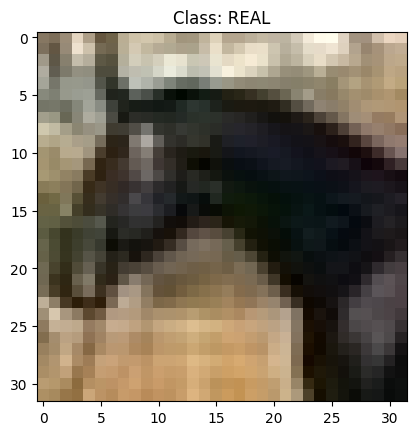

In [20]:
import matplotlib.pyplot as plt

# Extract images and labels from the first element
x, labels = next(iter(first_element))
images, tabular_data = x

plt.imshow(images[0].numpy().squeeze().astype("uint8"))
plt.title(f"Class: {image_dataset_train.class_names[labels[0].numpy().argmax()]}")
#     plt.axis('off')
plt.show()

In [21]:
labels

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

In [22]:
tabular_data

<tf.Tensor: shape=(32, 1, 2484), dtype=float64, numpy=
array([[[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       ...,

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.        , 36.93237063, 44.55333882, ...,  0.        ,
          0.        ,  0.        ]]])>

In [23]:
norm = tf.keras.layers.Normalization()
norm.adapt(tabular_data)

In [24]:
from tensorflow.keras import layers

NUMBER_OF_CLASSES = 2

# Image part
img_input = layers.Input(shape=config["input_shape"], name='img_input')

img_X = layers.Conv2D(64, (3, 3))(img_input)
img_X = layers.BatchNormalization()(img_X)
img_X = layers.ReLU()(img_X)

img_output = layers.Flatten()(img_X)

# Radiomic part
tabular_input = layers.Input(shape=tuple(tabular_data.shape[1:]), name='tabular_input')
tabular_X = norm(tabular_input)

tabular_X = layers.Dense(32)(tabular_X)
tabular_X = layers.BatchNormalization()(tabular_X)
tabular_X = layers.ReLU()(tabular_X)

tabular_X = layers.Dropout(0.3)(tabular_X)

tabular_X = layers.Dense(16)(tabular_X)
tabular_X = layers.BatchNormalization()(tabular_X)
tabular_X = layers.ReLU()(tabular_X)

tabular_output = layers.Flatten()(tabular_X)

# Combine
combined = layers.Concatenate()([img_output, tabular_output])

# output
output = layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(combined)

# define model
keras_model = tf.keras.Model(inputs=[img_input, tabular_input], outputs=output)

keras_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tabular_input (InputLayer)     [(None, 1, 2484)]    0           []                               
                                                                                                  
 normalization (Normalization)  (None, 1, 2484)      4969        ['tabular_input[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 1, 32)        79520       ['normalization[0][0]']          
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 1, 32)       128         ['dense[0][0]']                  
 rmalization)                                                                                 

In [25]:
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

In [26]:
from wandb.keras import WandbCallback

EPOCHS = config["epochs"]

if config["use_small_sample"] is True:
    steps_per_epoch = 1000 // BATCH_SIZE
    validation_steps = 100 // BATCH_SIZE
else:
    # train_dataset.samples // BATCH_SIZE
    steps_per_epoch = None
    validation_steps = None
    
print(f"steps_per_epoch = {steps_per_epoch}, validation_steps = {validation_steps}\n\n")
    
history = keras_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[
      WandbCallback(),
    ],
    validation_steps=validation_steps
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


steps_per_epoch = None, validation_steps = None


Epoch 1/50
2813/2813 [==============================] - ETA: 0s - loss: 0.8535 - accuracy: 0.8273

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 242s 70ms/step - loss: 0.8535 - accuracy: 0.8273 - val_loss: 0.3365 - val_accuracy: 0.8812
Epoch 2/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.8965

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 235s 67ms/step - loss: 0.2724 - accuracy: 0.8965 - val_loss: 0.1936 - val_accuracy: 0.9215
Epoch 3/50
2813/2813 [==============================] - 207s 58ms/step - loss: 0.2229 - accuracy: 0.9116 - val_loss: 0.2094 - val_accuracy: 0.9173
Epoch 4/50
2813/2813 [==============================] - 238s 65ms/step - loss: 0.2113 - accuracy: 0.9162 - val_loss: 0.7352 - val_accuracy: 0.7705
Epoch 5/50
2813/2813 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9199

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.1s


2813/2813 [==============================] - 223s 63ms/step - loss: 0.2028 - accuracy: 0.9199 - val_loss: 0.1918 - val_accuracy: 0.9275
Epoch 6/50
2813/2813 [==============================] - 230s 65ms/step - loss: 0.1896 - accuracy: 0.9259 - val_loss: 2.5461 - val_accuracy: 0.6090
Epoch 7/50
2813/2813 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9307

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 226s 64ms/step - loss: 0.1764 - accuracy: 0.9307 - val_loss: 0.1328 - val_accuracy: 0.9504
Epoch 8/50
2813/2813 [==============================] - 219s 62ms/step - loss: 0.1679 - accuracy: 0.9337 - val_loss: 0.2343 - val_accuracy: 0.9140
Epoch 9/50
2813/2813 [==============================] - 232s 62ms/step - loss: 0.1594 - accuracy: 0.9377 - val_loss: 0.1337 - val_accuracy: 0.9515
Epoch 10/50
2813/2813 [==============================] - 213s 60ms/step - loss: 0.1533 - accuracy: 0.9404 - val_loss: 0.1637 - val_accuracy: 0.9376
Epoch 11/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.1451 - accuracy: 0.9430

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 214s 60ms/step - loss: 0.1450 - accuracy: 0.9430 - val_loss: 0.1048 - val_accuracy: 0.9596
Epoch 12/50
2813/2813 [==============================] - 214s 60ms/step - loss: 0.1366 - accuracy: 0.9464 - val_loss: 0.1472 - val_accuracy: 0.9439
Epoch 13/50
2813/2813 [==============================] - 217s 60ms/step - loss: 0.1326 - accuracy: 0.9477 - val_loss: 0.1484 - val_accuracy: 0.9375
Epoch 14/50
2813/2813 [==============================] - 215s 61ms/step - loss: 0.1263 - accuracy: 0.9514 - val_loss: 0.2272 - val_accuracy: 0.9165
Epoch 15/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9525

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 215s 60ms/step - loss: 0.1233 - accuracy: 0.9525 - val_loss: 0.0916 - val_accuracy: 0.9669
Epoch 16/50
2813/2813 [==============================] - 213s 60ms/step - loss: 0.1180 - accuracy: 0.9539 - val_loss: 0.0932 - val_accuracy: 0.9632
Epoch 17/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9551

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 214s 60ms/step - loss: 0.1150 - accuracy: 0.9551 - val_loss: 0.0873 - val_accuracy: 0.9679
Epoch 18/50
2813/2813 [==============================] - 215s 61ms/step - loss: 0.1105 - accuracy: 0.9572 - val_loss: 0.3588 - val_accuracy: 0.8787
Epoch 19/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9585

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 212s 60ms/step - loss: 0.1075 - accuracy: 0.9585 - val_loss: 0.0788 - val_accuracy: 0.9727
Epoch 20/50
2813/2813 [==============================] - 209s 59ms/step - loss: 0.1062 - accuracy: 0.9592 - val_loss: 0.0899 - val_accuracy: 0.9666
Epoch 21/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.1034 - accuracy: 0.9596

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 213s 60ms/step - loss: 0.1034 - accuracy: 0.9596 - val_loss: 0.0686 - val_accuracy: 0.9751
Epoch 22/50
2813/2813 [==============================] - 212s 60ms/step - loss: 0.0984 - accuracy: 0.9617 - val_loss: 0.1456 - val_accuracy: 0.9451
Epoch 23/50
2813/2813 [==============================] - 1712s 594ms/step - loss: 0.0966 - accuracy: 0.9623 - val_loss: 0.1043 - val_accuracy: 0.9602
Epoch 24/50
2813/2813 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9635

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 224s 62ms/step - loss: 0.0971 - accuracy: 0.9635 - val_loss: 0.0629 - val_accuracy: 0.9772
Epoch 25/50
2813/2813 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9642

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 236s 68ms/step - loss: 0.0924 - accuracy: 0.9642 - val_loss: 0.0585 - val_accuracy: 0.9792
Epoch 26/50
2813/2813 [==============================] - 217s 61ms/step - loss: 0.0906 - accuracy: 0.9652 - val_loss: 0.1378 - val_accuracy: 0.9479
Epoch 27/50
2813/2813 [==============================] - 226s 63ms/step - loss: 0.0885 - accuracy: 0.9659 - val_loss: 0.1385 - val_accuracy: 0.9462
Epoch 28/50
2813/2813 [==============================] - 219s 61ms/step - loss: 0.0853 - accuracy: 0.9669 - val_loss: 0.0979 - val_accuracy: 0.9616
Epoch 29/50
2813/2813 [==============================] - 226s 63ms/step - loss: 0.0835 - accuracy: 0.9686 - val_loss: 0.1228 - val_accuracy: 0.9506
Epoch 30/50
2813/2813 [==============================] - 239s 67ms/step - loss: 0.0828 - accuracy: 0.9676 - val_loss: 0.0645 - val_accuracy: 0.9759
Epoch 31/50
2813/2813 [==============================] - 237s 66ms/step - loss: 0.0818 - accuracy: 0.9684 - val_loss: 0.1407

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 227s 64ms/step - loss: 0.0770 - accuracy: 0.9710 - val_loss: 0.0540 - val_accuracy: 0.9805
Epoch 35/50
2813/2813 [==============================] - 221s 62ms/step - loss: 0.0752 - accuracy: 0.9706 - val_loss: 0.0635 - val_accuracy: 0.9765
Epoch 36/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9717

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 238s 66ms/step - loss: 0.0744 - accuracy: 0.9717 - val_loss: 0.0441 - val_accuracy: 0.9847
Epoch 37/50
2813/2813 [==============================] - 241s 68ms/step - loss: 0.0738 - accuracy: 0.9716 - val_loss: 0.0511 - val_accuracy: 0.9811
Epoch 38/50
2813/2813 [==============================] - 235s 64ms/step - loss: 0.0741 - accuracy: 0.9714 - val_loss: 0.0722 - val_accuracy: 0.9753
Epoch 39/50
2812/2813 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9730

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240520_232609-q9ljwasc/files/model-best)... Done. 0.0s


2813/2813 [==============================] - 234s 65ms/step - loss: 0.0707 - accuracy: 0.9730 - val_loss: 0.0350 - val_accuracy: 0.9893
Epoch 40/50
2813/2813 [==============================] - 226s 64ms/step - loss: 0.0702 - accuracy: 0.9734 - val_loss: 0.0489 - val_accuracy: 0.9839
Epoch 41/50
2813/2813 [==============================] - 229s 65ms/step - loss: 0.0688 - accuracy: 0.9741 - val_loss: 0.0410 - val_accuracy: 0.9854
Epoch 42/50
2813/2813 [==============================] - 251s 69ms/step - loss: 0.0680 - accuracy: 0.9739 - val_loss: 0.0450 - val_accuracy: 0.9837
Epoch 43/50
2813/2813 [==============================] - 235s 65ms/step - loss: 0.0679 - accuracy: 0.9740 - val_loss: 0.0427 - val_accuracy: 0.9841
Epoch 44/50
2813/2813 [==============================] - 220s 61ms/step - loss: 0.0672 - accuracy: 0.9742 - val_loss: 0.0361 - val_accuracy: 0.9876
Epoch 45/50
2813/2813 [==============================] - 222s 62ms/step - loss: 0.0661 - accuracy: 0.9753 - val_loss: 0.0723

In [27]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:     accuracy ▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
wandb:        epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:         loss █▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_accuracy ▆▇▇▄▁▇▇▇▇▇▇▇██▆██▇▇█▇▇▇▇▇███████████▇███
wandb:     val_loss ▂▁▁▃█▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.97739
wandb:    best_epoch 38
wandb: best_val_loss 0.03499
wandb:         epoch 49
wandb:          loss 0.05969
wandb:  val_accuracy 0.98718
wandb:      val_loss 0.03824
wandb: 
wandb: 🚀 View run cerulean-sound-110 at: https://wandb.ai/budalema/ai-detection/runs/q9ljwasc
wandb: Synced 6 W&B file(s), 1 media file(s), 56 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20240520_232609-q9ljwasc/logs
